In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from tqdm import tqdm
from sklearn.metrics import hamming_loss

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import PIL
import pandas as pd
import os
class Dataset(Dataset):
    def __init__(self, csv_path, img_path, transform=None):
        df = pd.read_csv(csv_path)
        assert df['fname'].apply(lambda x: os.path.isfile(img_path + x)).all
        
        self.img_path = img_path
        self.transform = transform

        self.X = df['fname']
        self.y = df.drop(columns=['fname'])
    def __getitem__(self, index):
        
        img = PIL.Image.open(self.img_path + self.X[index])
        if self.transform is not None:
            img = self.transform(img)
        
        label = torch.from_numpy(self.y.iloc[index].values).type(torch.FloatTensor)
        return img, label

    def __len__(self):
        return len(self.X)
    
def label2cat(x):
    return [label for i, label in enumerate(["desert", "mountains", "sea", "sunset", "trees"]) if x[i] == 1]

def inv_norm(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    x = image.new(*image.size())    
    x[:, 0, :, :] = image[:, 0, :, :] * std[0] + mean[0]
    x[:, 1, :, :] = image[:, 1, :, :] * std[1] + mean[1]
    x[:, 2, :, :] = image[:, 2, :, :] * std[2] + mean[2]    
    return x

In [4]:
bs = 32

train_transform = transforms.Compose([transforms.RandomRotation(10),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])


train_set = Dataset('dataset_multilabel/train_label.csv','dataset_multilabel/train/', transform=train_transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = Dataset('dataset_multilabel/test_label.csv','dataset_multilabel/test/',transform=test_transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=bs, shuffle=True)

In [5]:
images, labels = next(iter(testloader))
images = inv_norm(images)
images = images[0, :, :, :].numpy()
images = images.transpose([1, 2, 0])

In [6]:
images.shape

(224, 224, 3)

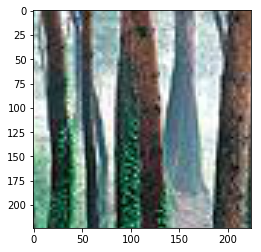

In [7]:
plt.imshow(images)

# Training Preparation M C O S

In [8]:
from torchvision.models import resnet18

In [9]:
model = resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False # Untuk nge freeze
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, out_features=5, bias=True),
    nn.Sigmoid()
)

model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr = 1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, min_lr=1e-8)

In [10]:
# Config
model_name = 'resnet.pth'
save_every = 10
plot_every = 10
early_stop_patience = 10

# Initialization
train_cost, test_cost = [], []
train_acc, test_acc = [], []
best_acc = 0
best_weights = model.state_dict()
epoch = early_stop = 0

# Fase 1 Training Classifier

In [11]:
while True:
    epoch += 1
    
    ## Training ##
    cost = acc = 0
    model.train()    
    for images, labels in tqdm(trainloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        cost += loss.item()*images.shape[0]
        labels = labels.cpu().detach().numpy()
        pred = output > 0.5
        pred = pred.cpu().detach().numpy()                
        acc += (1-hamming_loss(labels, pred))
    scheduler.step(cost)
    train_cost.append(cost/len(trainloader.dataset))
    train_acc.append(acc/len(trainloader))
    
    ## Testing ##
    with torch.no_grad():
        cost = acc = 0
        model.eval()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
        
            output = model(images)
            loss = criterion(output, labels)            
            
            cost += loss.item()*images.shape[0]
            labels = labels.cpu().detach().numpy()
            pred = output > 0.5
            pred = pred.cpu().detach().numpy()                
            acc += (1-hamming_loss(labels, pred))
        scheduler.step(cost)
        test_cost.append(cost/len(testloader.dataset))
        test_acc.append(acc/len(testloader))
        
    ## Reporting ##
    print(f'Epoch {epoch:4}')
    print(f'Train_loss = {train_cost[-1]:.3f} | Test_loss = {test_cost[-1]:.3f}')
    print(f'Train_acc = {train_acc[-1]*100:.1f}% | Test_acc = {test_acc[-1]*100:.1f}%')    
    
    
    ## Common Callback ##
    # Early Stopping
    if test_acc[-1] > best_acc:
        best_acc = test_acc[-1]
        best_weights = model.state_dict()
        early_stop = 0
    else:
        early_stop += 1
        print(f'==> EarlyStop patience = {early_stop}')
        if early_stop >= early_stop_patience:
            print('==> Execute Early Stopping')
            ckpt = {
                'loss_history': (train_cost, test_cost),
                'acc_history': (train_acc, test_acc),
                'weight': best_weights
            }
            os.makedirs('model', exist_ok=True)
            torch.save(ckpt, f'model/{model_name}')
            break

    # Checkpoint            
    if epoch % save_every == 0:
        ckpt = {
            'loss_history': (train_cost, test_cost),
            'acc_history': (train_acc, test_acc),
            'weight': best_weights
        }
        os.makedirs('model', exist_ok=True)
        torch.save(ckpt, f'model/{model_name}')
        
    # Runtime Plotting
    if epoch % plot_every == 0:
        plt.pause(0.001)
        plt.semilogy(range(1, len(train_cost)+1), train_cost)
        plt.semilogy(range(1, len(test_cost)+1), test_cost)
        plt.ylabel('Cost')
        plt.xlabel('Epoch');

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch    1
Train_loss = 0.542 | Test_loss = 0.503
Train_acc = 74.6% | Test_acc = 77.4%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch    2
Train_loss = 0.498 | Test_loss = 0.467
Train_acc = 76.6% | Test_acc = 79.4%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch    3
Train_loss = 0.475 | Test_loss = 0.444
Train_acc = 78.0% | Test_acc = 80.0%


 73%|███████▎  | 37/51 [02:42<01:17,  5.51s/it]

KeyboardInterrupt: 

# Fase 2 Fine Tuning

In [ ]:
for param in model.parameters():
    param.requires_grad = True # Untuk nge defreeze

model = model.to(device)
optimizer = optim.RMSprop(model.parameters(), lr = 1e-5)

In [ ]:
# Config
model_name = 'resnet_fine_tuned.pth'
save_every = 10
plot_every = 10
early_stop_patience = 10

# Initialization
train_cost, test_cost = ckpt["loss_history"]
train_acc, test_acc = ckpt["acc_history"]
best_acc = max(test_acc)
best_weights = model.state_dict()
epoch = early_stop = 0

In [1]:
while True:
    epoch += 1
    
    ## Training ##
    cost = acc = 0
    model.train()    
    for images, labels in tqdm(trainloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        cost += loss.item()*images.shape[0]
        labels = labels.cpu().detach().numpy()
        pred = output > 0.5
        pred = pred.cpu().detach().numpy()                
        acc += (1-hamming_loss(labels, pred))
    scheduler.step(cost)
    train_cost.append(cost/len(trainloader.dataset))
    train_acc.append(acc/len(trainloader))
    
    ## Testing ##
    with torch.no_grad():
        cost = acc = 0
        model.eval()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
        
            output = model(images)
            loss = criterion(output, labels)            
            
            cost += loss.item()*images.shape[0]
            labels = labels.cpu().detach().numpy()
            pred = output > 0.5
            pred = pred.cpu().detach().numpy()                
            acc += (1-hamming_loss(labels, pred))
        scheduler.step(cost)
        test_cost.append(cost/len(testloader.dataset))
        test_acc.append(acc/len(testloader))
        
    ## Reporting ##
    print(f'Epoch {epoch:4}')
    print(f'Train_loss = {train_cost[-1]:.3f} | Test_loss = {test_cost[-1]:.3f}')
    print(f'Train_acc = {train_acc[-1]*100:.1f}% | Test_acc = {test_acc[-1]*100:.1f}%')    
    
    
    ## Common Callback ##
    # Early Stopping
    if test_acc[-1] > best_acc:
        best_acc = test_acc[-1]
        best_weights = model.state_dict()
        early_stop = 0
    else:
        early_stop += 1
        print(f'==> EarlyStop patience = {early_stop}')
        if early_stop >= early_stop_patience:
            print('==> Execute Early Stopping')
            ckpt = {
                'loss_history': (train_cost, test_cost),
                'acc_history': (train_acc, test_acc),
                'weight': best_weights
            }
            os.makedirs('model', exist_ok=True)
            torch.save(ckpt, f'model/{model_name}')
            break

    # Checkpoint            
    if epoch % save_every == 0:
        ckpt = {
            'loss_history': (train_cost, test_cost),
            'acc_history': (train_acc, test_acc),
            'weight': best_weights
        }
        os.makedirs('model', exist_ok=True)
        torch.save(ckpt, f'model/{model_name}')
        
    # Runtime Plotting
    if epoch % plot_every == 0:
        plt.pause(0.001)
        plt.semilogy(range(1, len(train_cost)+1), train_cost)
        plt.semilogy(range(1, len(test_cost)+1), test_cost)
        plt.ylabel('Cost')
        plt.xlabel('Epoch');

NameError: name 'epoch' is not defined

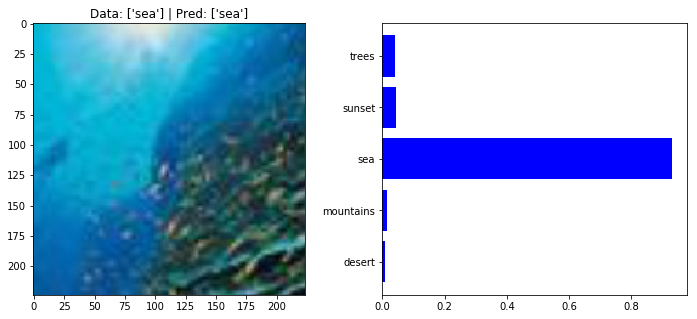

In [15]:
from torchvision.models import resnet18
model = resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 5),
    nn.Sigmoid()
)

ckpt = torch.load("model/resnet_finetuned.pth", map_location='cpu')
model.load_state_dict(ckpt['weight'])
model = model.to(device)
with torch.no_grad():
    model.eval()
    images, labels = next(iter(testloader))
    images = images[0:1, :, :, :].to(device)
    labels = labels[0].to(device)
    
    output = model(images)
    pred = output > 0.5
    
    images = inv_norm(images)
    
    images = images.squeeze().cpu().numpy().transpose([1, 2, 0])
    output = output.squeeze()
    pred = pred.squeeze().cpu().numpy()
    labels = labels.cpu().numpy()
    
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.imshow(images)
    plt.title(f"Data: {label2cat(labels)} | Pred: {label2cat(pred)}")
    plt.subplot(122)
    plt.barh(range(1,6), output, color='b', tick_label=["desert", "mountains", "sea", "sunset", "trees"]);